In [1]:
#import libs
import os, glob
import pandas as pd
import plotly.offline as pyo
import plotly.graph_objs as go
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, timedelta
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import warnings
warnings.simplefilter("ignore")

In [2]:
#Merge CSVs
path = "log"
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
df_merged   = pd.concat(df_from_each_file, ignore_index=True)

In [3]:
df = df_merged.copy()
df.head()

,,Severity,Name,Alarm Source,Occurred On (NT),Cleared On (NT),Type,Clearance Status,Alarm Duration
0,\t\t-,Minor,Task execution failure alarm,OSS,9/17/2021 19:39,1/22/2022 15:16,QoS,Cleared,3043 hours 36 minutes 45 seconds
1,\t\t-,Minor,Task execution failure alarm,OSS,9/18/2021 21:35,1/22/2022 15:16,QoS,Cleared,3017 hours 40 minutes 50 seconds
2,\t\t-,Minor,Task execution failure alarm,OSS,9/17/2021 19:40,1/22/2022 15:16,QoS,Cleared,3043 hours 35 minutes 25 seconds
3,\t\t-,Minor,Task execution failure alarm,OSS,9/18/2021 22:08,1/22/2022 15:16,QoS,Cleared,3017 hours 7 minutes 31 seconds
4,\t\t-,Minor,Task execution failure alarm,OSS,9/18/2021 21:58,1/22/2022 15:16,QoS,Cleared,3017 hours 17 minutes 30 seconds


In [4]:
df = df[['Severity','Name','Alarm Source','Occurred On (NT)','Cleared On (NT)','Type','Alarm Duration']]
df.head()

,Severity,Name,Alarm Source,Occurred On (NT),Cleared On (NT),Type,Alarm Duration
0,Minor,Task execution failure alarm,OSS,9/17/2021 19:39,1/22/2022 15:16,QoS,3043 hours 36 minutes 45 seconds
1,Minor,Task execution failure alarm,OSS,9/18/2021 21:35,1/22/2022 15:16,QoS,3017 hours 40 minutes 50 seconds
2,Minor,Task execution failure alarm,OSS,9/17/2021 19:40,1/22/2022 15:16,QoS,3043 hours 35 minutes 25 seconds
3,Minor,Task execution failure alarm,OSS,9/18/2021 22:08,1/22/2022 15:16,QoS,3017 hours 7 minutes 31 seconds
4,Minor,Task execution failure alarm,OSS,9/18/2021 21:58,1/22/2022 15:16,QoS,3017 hours 17 minutes 30 seconds


In [5]:
#We Don't need OSS Alarms
df.drop(df[df['Alarm Source'] =='OSS'].index, inplace=True)

In [6]:
#Check Missing Values
def check_missing(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(20)

check_missing(df)

,Total,Percent
Alarm Duration,0,0.0
Type,0,0.0
Cleared On (NT),0,0.0
Occurred On (NT),0,0.0
Alarm Source,0,0.0
Name,0,0.0
Severity,0,0.0


In [7]:
#check duplicate rows
def check_duplicate(data):
    duplicate = data.duplicated()
    unique_data  = pd.Series(data.shape[0] - duplicate.value_counts()[1])
    duplicate_data = pd.Series(data.shape[0] - duplicate.value_counts()[0])
    unique_data_percent = pd.Series((unique_data/data.shape[0])*100)
    duplicate_data_percent = pd.Series((duplicate_data/data.shape[0])*100)
    dub = pd.concat([unique_data, duplicate_data,unique_data_percent,duplicate_data_percent], axis=1, keys=['Unique Count', 'Duplicate Count','Unique percent','Duplicate Percent'])
    return dub

check_duplicate(df)

,Unique Count,Duplicate Count,Unique percent,Duplicate Percent
0,6400938,1026319,86.181722,13.818278


In [6]:
#Drop duplicates
df.drop_duplicates(inplace=True)

In [9]:
print("Total Number of Alarms : {}".format(df.shape[0]))

Total Number of Alarms : 6400938


In [10]:
print('Number of unique Alarms: {}'.format(len(df['Name'].unique())))

Number of unique Alarms: 163


In [11]:
print('Number of Alarm Source : {}'.format(len(df['Alarm Source'].unique())))

Number of Alarm Source : 1465


In [12]:
df['Alarm_Duration_Hour'] = (pd.to_datetime(df['Cleared On (NT)'])-pd.to_datetime(df['Occurred On (NT)']))/ pd.Timedelta(hours=1)
df = df[['Severity','Name','Alarm Source','Occurred On (NT)','Cleared On (NT)','Type','Alarm_Duration_Hour']]
df.head()

,Severity,Name,Alarm Source,Occurred On (NT),Cleared On (NT),Type,Alarm_Duration_Hour
40,Major,IKE Negotiation Failure,LSINS38284,10/13/2021 14:38,10/14/2021 10:38,Trunk system,20.000000
41,Major,Cell Unavailable,LDELE54858,10/13/2021 14:39,10/13/2021 14:39,Signaling system,0.000000
42,Minor,SCTP Link Congestion,LCAIN10797,10/13/2021 14:38,10/13/2021 14:40,Trunk system,0.033333
43,Major,SCTP Link Fault,LSINS26375,10/13/2021 14:38,10/13/2021 15:38,Trunk system,1.000000
44,Major,User Plane Path Fault,LCAIE12478,10/13/2021 14:39,10/13/2021 15:37,Trunk system,0.966667


Text(0.5, 1.0, 'Severity Percentage')

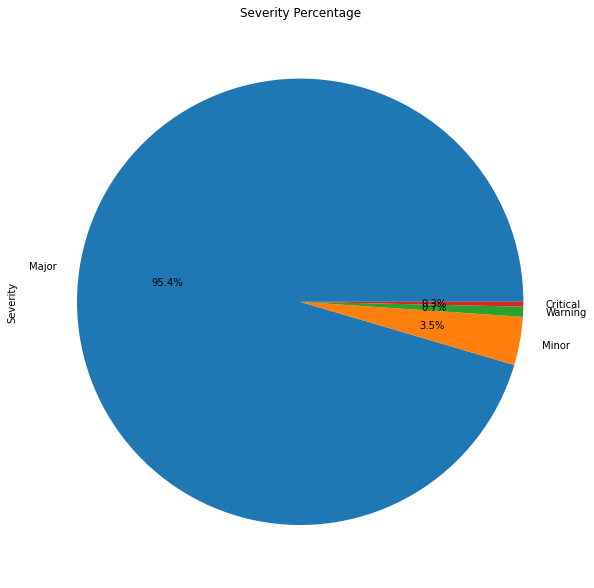

In [13]:
df['Severity'].value_counts().plot(kind='pie',figsize=[10,15],autopct='%1.1f%%')
plt.title('Severity Percentage')

Text(0.5, 1.0, 'Count of Types')

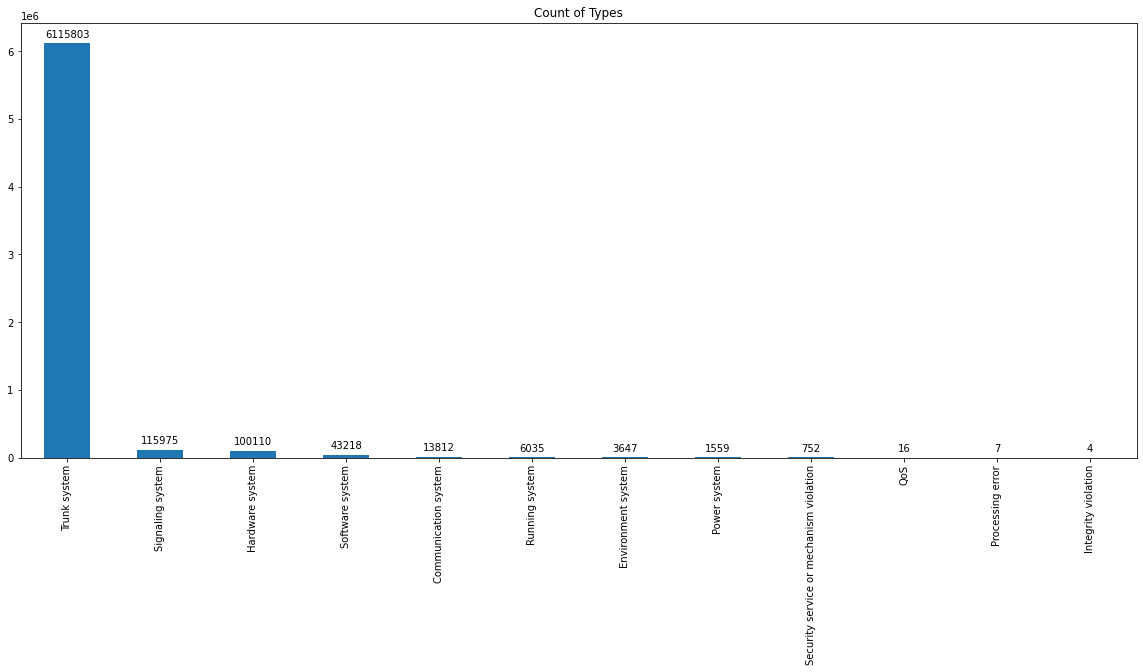

In [14]:
ax = df['Type'].value_counts().plot(kind='bar',figsize=[20,8])
for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title('Count of Types')

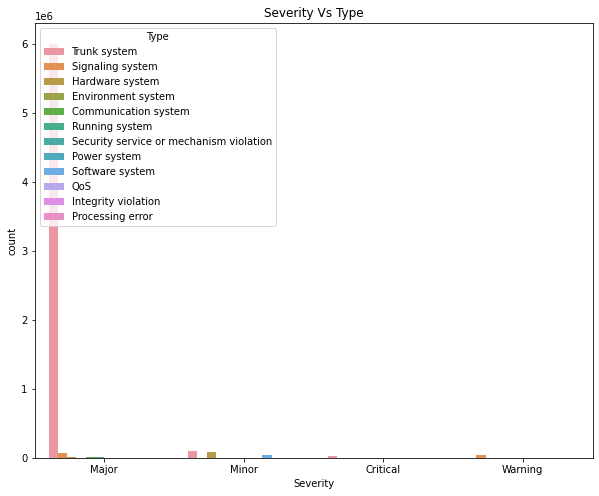

In [15]:
fig, axs = plt.subplots(figsize = (10,8))
fig = sns.countplot(x="Severity", hue ='Type', data = df)
plt.title('Severity Vs Type')
plt.show()

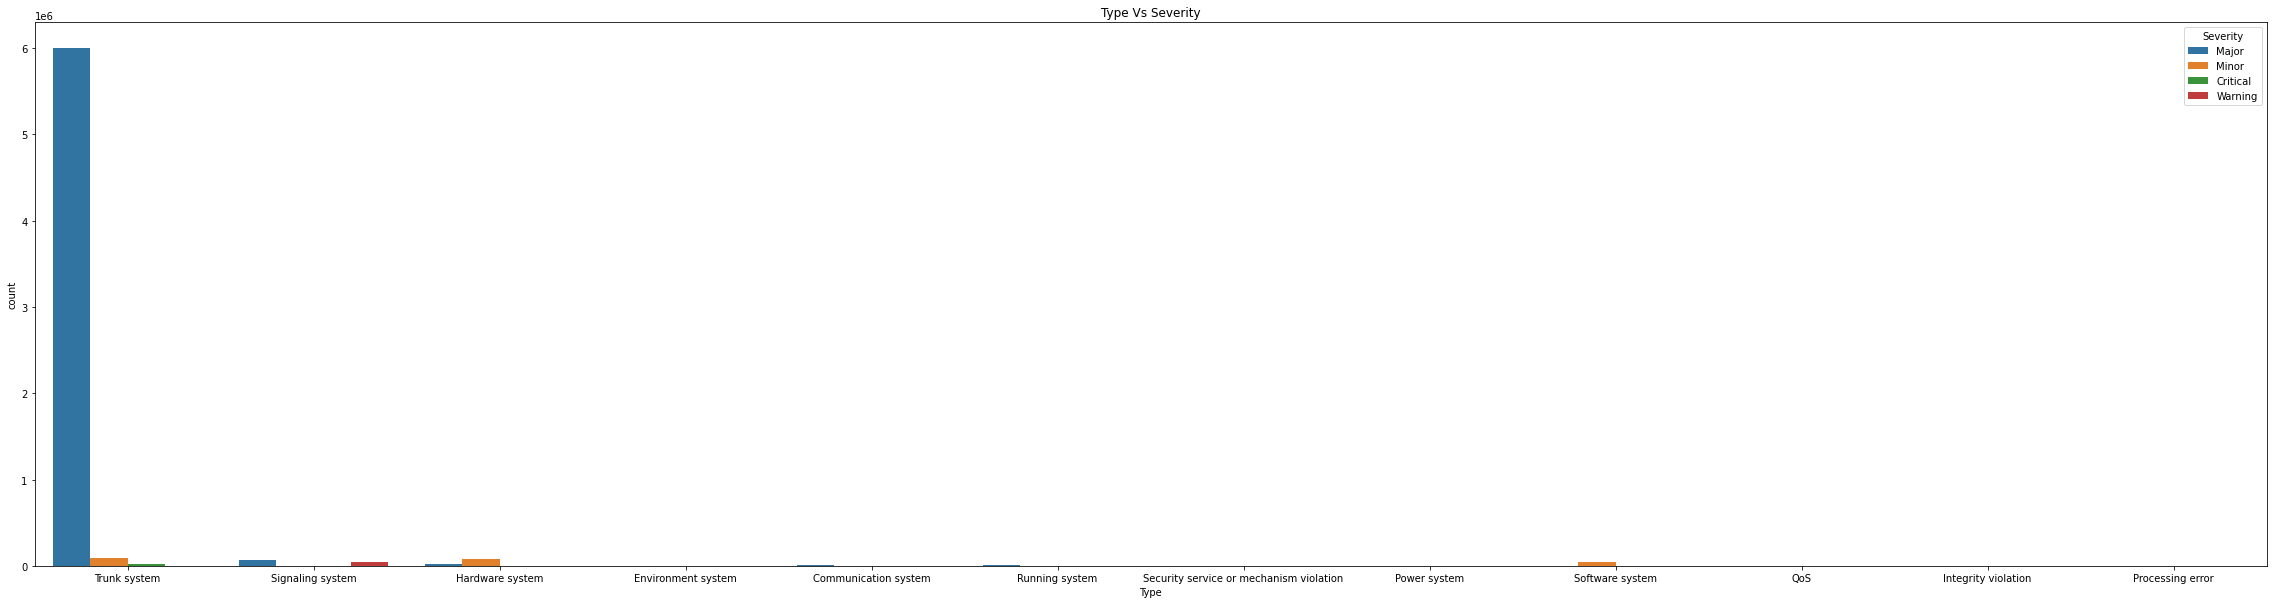

In [16]:
fig, axs = plt.subplots(figsize = (40,10))
sns.countplot(x="Type", hue ='Severity', data = df)
plt.title('Type Vs Severity')
plt.show()

<AxesSubplot:>

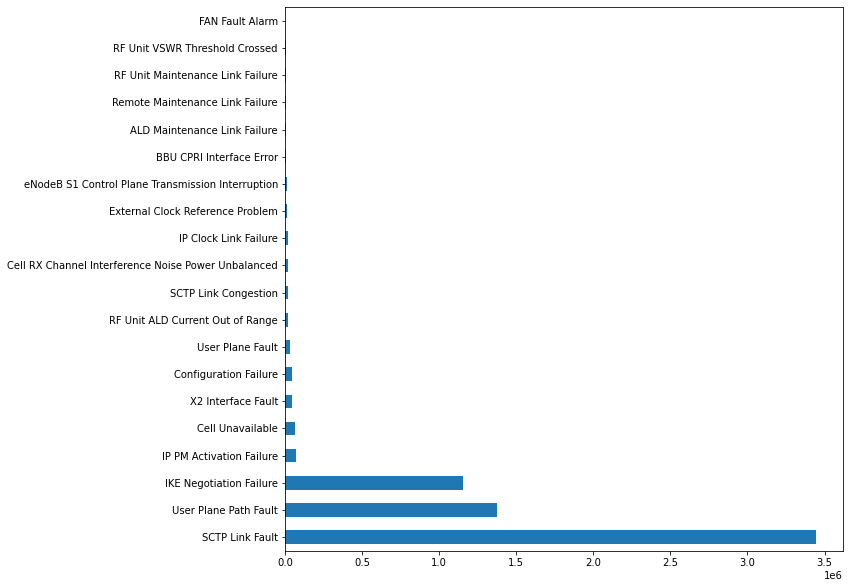

In [17]:
df['Name'].value_counts().head(20).plot(kind='barh',figsize=[10,10])

Text(0.5, 1.0, 'Top 20 Sites')

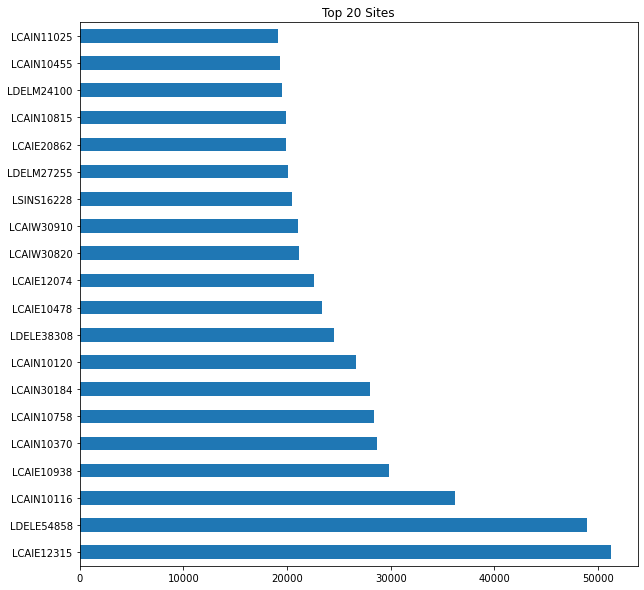

In [18]:
df['Alarm Source'].value_counts().head(20).plot(kind='barh',figsize=[10,10])
plt.title('Top 20 Sites')

In [19]:
pd.to_datetime(df['Occurred On (NT)']).dt.month.unique()

array([10, 11, 12], dtype=int64)

In [20]:
df['Alarm&Source']=df['Name'] + '_' + df['Alarm Source']
df.head()

,Severity,Name,Alarm Source,Occurred On (NT),Cleared On (NT),Type,Alarm_Duration_Hour,Alarm&Source
40,Major,IKE Negotiation Failure,LSINS38284,10/13/2021 14:38,10/14/2021 10:38,Trunk system,20.000000,IKE Negotiation Failure_LSINS38284
41,Major,Cell Unavailable,LDELE54858,10/13/2021 14:39,10/13/2021 14:39,Signaling system,0.000000,Cell Unavailable_LDELE54858
42,Minor,SCTP Link Congestion,LCAIN10797,10/13/2021 14:38,10/13/2021 14:40,Trunk system,0.033333,SCTP Link Congestion_LCAIN10797
43,Major,SCTP Link Fault,LSINS26375,10/13/2021 14:38,10/13/2021 15:38,Trunk system,1.000000,SCTP Link Fault_LSINS26375
44,Major,User Plane Path Fault,LCAIE12478,10/13/2021 14:39,10/13/2021 15:37,Trunk system,0.966667,User Plane Path Fault_LCAIE12478


In [21]:
len(df['Alarm&Source'].unique())

20885

Text(0.5, 1.0, 'Top 20 Sites')

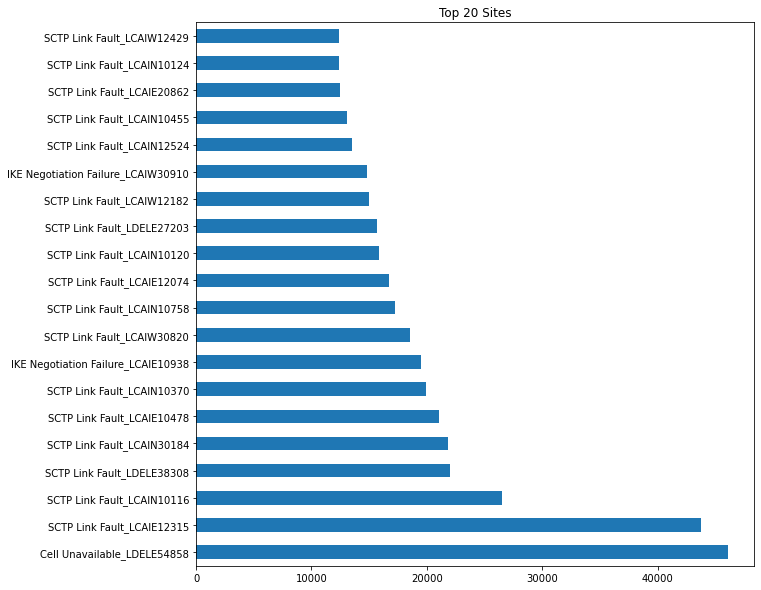

In [22]:
df['Alarm&Source'].value_counts().head(20).plot(kind='barh',figsize=[10,10])
plt.title('Top 20 Sites')

In [23]:
df['Alarm_Duration_Hour'].mean()

4.384720745824167

In [62]:
#Site alarms
data=[]
snap = df[df['Alarm Source']=='LCAIE12478']
for i in snap['Name'].unique():
    snap2 = snap[snap['Name']==i]
    trace = go.Scatter(x=pd.to_datetime(snap2['Occurred On (NT)']),y=snap2['Name'],name=i,mode='markers')
    data.append(trace)
layout = go.Layout(title='Alarms per time for LCAIE12478', xaxis ={'title':'time'},yaxis={'title':'Alarm'}, hovermode = 'x unified')
fig = go.Figure(data=data, layout=layout)
pyo.plot(fig, filename='Alarms per time for LCAIE12478.html')

'Alarms per time for LCAIE12478.html'

# Clsutering LCAIE12478

In [61]:
snap = df[df['Alarm Source']=='LCAIE12478'].copy()
snap.head(2)

,Severity,Name,Alarm Source,Occurred On (NT),Cleared On (NT),Type,Alarm_Duration_Hour,Alarm&Source
44,Major,User Plane Path Fault,LCAIE12478,10/13/2021 14:39,10/13/2021 15:37,Trunk system,0.966667,User Plane Path Fault_LCAIE12478
390,Major,IKE Negotiation Failure,LCAIE12478,10/13/2021 14:53,10/13/2021 14:54,Trunk system,0.016667,IKE Negotiation Failure_LCAIE12478


In [ ]:
Occurred_year = pd.DataFrame(pd.DatetimeIndex(snap['Occurred On (NT)']).year)
Occurred_month = pd.DataFrame(pd.DatetimeIndex(snap['Occurred On (NT)']).month)
Occurred_day = pd.DataFrame(pd.DatetimeIndex(snap['Occurred On (NT)']).day)
Occurred_hour = pd.DataFrame(pd.DatetimeIndex(snap['Occurred On (NT)']).hour)
Occurred_minute = pd.DataFrame(pd.DatetimeIndex(snap['Occurred On (NT)']).minute)
Occurred_second = pd.DataFrame(pd.DatetimeIndex(snap['Occurred On (NT)']).second)
Cleared_year = pd.DataFrame(pd.DatetimeIndex(snap['Cleared On (NT)']).year)
Cleared_month = pd.DataFrame(pd.DatetimeIndex(snap['Cleared On (NT)']).month)
Cleared_day = pd.DataFrame(pd.DatetimeIndex(snap['Cleared On (NT)']).day)
Cleared_hour = pd.DataFrame(pd.DatetimeIndex(snap['Cleared On (NT)']).hour)
Cleared_minute = pd.DataFrame(pd.DatetimeIndex(snap['Cleared On (NT)']).minute)
Cleared_second = pd.DataFrame(pd.DatetimeIndex(snap['Cleared On (NT)']).second)

data = pd.concat([Occurred_year,Occurred_month],axis=1)
data = pd.concat([data,Occurred_day],axis=1)
data = pd.concat([data,Occurred_hour],axis=1)
data = pd.concat([data,Occurred_second],axis=1)
data = pd.concat([data,Cleared_year],axis=1)
data = pd.concat([data,Cleared_month],axis=1)
data = pd.concat([data,Cleared_hour],axis=1)
data = pd.concat([data,Cleared_minute],axis=1)
data = pd.concat([data,Cleared_second],axis=1)

all_data_finish = data.set_axis(['Occurred_year', 'Occurred_month', 'Occurred_day',
                                 'Occurred_hour', 'Occurred_second', 'Cleared_year',
                                 'Cleared_month','Cleared_hour','Cleared_minute',
                                 'Cleared_second'], axis=1, inplace=False)
all_data_finish.head(2)

In [28]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

# Define dataframe's function and the column to return a dataframe later OHE
def OneHotEncoding(df, column):
    label = LabelEncoder()
    encoding=label.fit_transform(df[column]).reshape(-1,1)
    encoder = OneHotEncoder(sparse=False)
    column = [column+ "_"+ str(i) for i in label.classes_]
    data = encoder.fit_transform(encoding)
    return(pd.DataFrame(data,columns =column))

In [29]:
snap2 = snap[['Severity','Name','Type']]
types = pd.DataFrame(snap2.dtypes)

#encoding categories and add finished column to dataframe with ready features
categories = types.index[types[0] == 'O'].values
for column in categories:
    df = OneHotEncoding(snap2,column)
    all_data_finish = pd.concat([all_data_finish,df],axis=1)
    print("Column ",column, " tranform!")

Column  Severity  tranform!
Column  Name  tranform!
Column  Type  tranform!


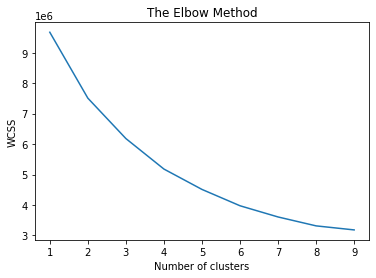

In [30]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(all_data_finish)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [31]:
kmeans = KMeans(n_clusters =4 , init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(all_data_finish)

In [32]:
snap['cluster']=y_kmeans
snap.head(2)

,Severity,Name,Alarm Source,Occurred On (NT),Cleared On (NT),Type,Alarm_Duration_Hour,Alarm&Source,cluster
44,Major,User Plane Path Fault,LCAIE12478,10/13/2021 14:39,10/13/2021 15:37,Trunk system,0.966667,User Plane Path Fault_LCAIE12478,1
390,Major,IKE Negotiation Failure,LCAIE12478,10/13/2021 14:53,10/13/2021 14:54,Trunk system,0.016667,IKE Negotiation Failure_LCAIE12478,1


In [33]:
#Site alarms
data=[]
for i in snap['Name'].unique():
    snap2 = snap[(snap['Name']==i)]
    trace = go.Scatter(x=pd.to_datetime(snap2['Occurred On (NT)']),y=snap2['Name'],name=i,mode='markers', marker=dict(color=snap2['cluster'].map({0:'red',1:'yellow',2:'green',3:'blue',4:'black',5:'pink'})))
    data.append(trace)
layout = go.Layout(title='Alarms per time for LCAIE12478', xaxis ={'title':'time'},yaxis={'title':'Alarm'})
fig = go.Figure(data=data, layout=layout)
pyo.plot(fig, filename='Alarms per time for LCAIE12478_cluster.html')

'Alarms per time for LCAIE12478_cluster.html'

# Label Encoding

In [88]:
snap = df[df['Alarm Source']=='LDELE54858'].copy()
snap.head(2)

,Severity,Name,Alarm Source,Occurred On (NT),Cleared On (NT),Type,Alarm_Duration_Hour,Alarm&Source
41,Major,Cell Unavailable,LDELE54858,10/13/2021 14:39,10/13/2021 14:39,Signaling system,0.000000,Cell Unavailable_LDELE54858
48,Major,Cell Unavailable,LDELE54858,10/13/2021 14:39,10/13/2021 14:44,Signaling system,0.083333,Cell Unavailable_LDELE54858


In [89]:
# Import label encoder
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in columns
snap['En_Severity']= label_encoder.fit_transform(snap['Severity'])
snap['En_Name']= label_encoder.fit_transform(snap['Name'])
snap['En_Type']= label_encoder.fit_transform(snap['Type'])
snap.head()

,Severity,Name,Alarm Source,Occurred On (NT),Cleared On (NT),Type,Alarm_Duration_Hour,Alarm&Source,En_Severity,En_Name,En_Type
41,Major,Cell Unavailable,LDELE54858,10/13/2021 14:39,10/13/2021 14:39,Signaling system,0.000000,Cell Unavailable_LDELE54858,1,0,2
48,Major,Cell Unavailable,LDELE54858,10/13/2021 14:39,10/13/2021 14:44,Signaling system,0.083333,Cell Unavailable_LDELE54858,1,0,2
51,Major,Cell Unavailable,LDELE54858,10/13/2021 14:39,10/13/2021 14:44,Signaling system,0.083333,Cell Unavailable_LDELE54858,1,0,2
268,Major,Cell Unavailable,LDELE54858,10/13/2021 14:44,10/13/2021 14:46,Signaling system,0.033333,Cell Unavailable_LDELE54858,1,0,2
269,Major,Cell Unavailable,LDELE54858,10/13/2021 14:44,10/13/2021 14:46,Signaling system,0.033333,Cell Unavailable_LDELE54858,1,0,2


In [90]:
snap['En_Occurred_year'] = pd.DatetimeIndex(snap['Occurred On (NT)']).year
snap['En_Occurred_month'] = pd.DatetimeIndex(snap['Occurred On (NT)']).month
snap['En_Occurred_day'] = pd.DatetimeIndex(snap['Occurred On (NT)']).day
snap['En_Occurred_hour'] = pd.DatetimeIndex(snap['Occurred On (NT)']).hour
snap['En_Occurred_minute'] = pd.DatetimeIndex(snap['Occurred On (NT)']).minute
snap['En_Occurred_second'] = pd.DatetimeIndex(snap['Occurred On (NT)']).second
snap['En_Cleared_year'] = pd.DatetimeIndex(snap['Cleared On (NT)']).year
snap['En_Cleared_month'] = pd.DatetimeIndex(snap['Cleared On (NT)']).month
snap['En_Cleared_day'] = pd.DatetimeIndex(snap['Cleared On (NT)']).day
snap['En_Cleared_hour'] = pd.DatetimeIndex(snap['Cleared On (NT)']).hour
snap['En_Cleared_minute'] = pd.DatetimeIndex(snap['Cleared On (NT)']).minute
snap['En_Cleared_second'] = pd.DatetimeIndex(snap['Cleared On (NT)']).second

In [91]:
snap2 = snap[['En_Severity', 'En_Name', 'En_Type', 'En_Occurred_year',
       'En_Occurred_month', 'En_Occurred_day', 'En_Occurred_hour',
       'En_Occurred_minute', 'En_Occurred_second', 'En_Cleared_year',
       'En_Cleared_month', 'En_Cleared_day', 'En_Cleared_hour',
       'En_Cleared_minute', 'En_Cleared_second', 'Alarm_Duration_Hour']].copy()
snap2.head(2)

,En_Severity,En_Name,En_Type,En_Occurred_year,En_Occurred_month,En_Occurred_day,En_Occurred_hour,En_Occurred_minute,En_Occurred_second,En_Cleared_year,En_Cleared_month,En_Cleared_day,En_Cleared_hour,En_Cleared_minute,En_Cleared_second,Alarm_Duration_Hour
41,1,0,2,2021,10,13,14,39,0,2021,10,13,14,39,0,0.000000
48,1,0,2,2021,10,13,14,39,0,2021,10,13,14,44,0,0.083333


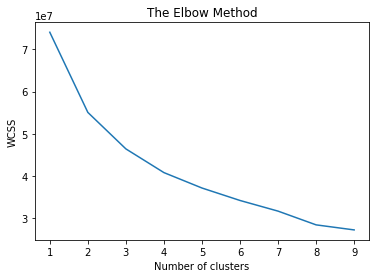

In [92]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(snap2)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [93]:
kmeans = KMeans(n_clusters =8 , init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(snap2)
snap['cluster']=y_kmeans

In [98]:
#Site alarms
data=[]
for i in snap['Name'].unique():
    snap3 = snap[(snap['Name']==i)&(snap['cluster']==4)]
    trace = go.Scatter(x=pd.to_datetime(snap3['Occurred On (NT)']),y=snap3['Name'],name=i,mode='markers')
    data.append(trace)
layout = go.Layout(title='Alarms per time for LDELE54858_cluster4', xaxis ={'title':'time'},yaxis={'title':'Alarm'})
fig = go.Figure(data=data, layout=layout)
pyo.plot(fig, filename='Alarms per time for LDELE54858_cluster4.html')

'Alarms per time for LDELE54858_cluster4.html'

# Market Basket Analysis MBA

In [47]:
# MBA one Site
snap = df[df['Alarm Source']=='LCAIN12215'].copy()
snap['q'] = 1
snap = snap[['Name','Alarm Source','Occurred On (NT)','q']]
basket = snap.groupby(['Alarm Source','Occurred On (NT)','Name'])['q'].sum().unstack().reset_index().fillna(0).set_index('Occurred On (NT)')
basket.drop(columns=['Alarm Source'],inplace=True)

def encode(x):
    if x <=0:
        return 0
    if x >=1:
        return 1

basket_encode = basket.applymap(encode)

basket_plus = basket_encode[(basket_encode>0).sum(axis=1)>=2]


In [58]:
freq_pattern = apriori(basket_plus,min_support=0.03,use_colnames=True).sort_values('support',ascending=False).reset_index(drop=True)
freq_pattern['len'] = freq_pattern['itemsets'].apply(lambda x: len(x))
freq_pattern[freq_pattern['len']>1]

,support,itemsets,len
2,0.666667,"(SCTP Link Fault, User Plane Path Fault)",2
4,0.200000,"(SCTP Link Fault, IKE Negotiation Failure)",2
6,0.133333,"(License on Trial, SCTP Link Fault)",2
8,0.066667,"(License on Trial, X2 Interface Fault)",2
9,0.066667,"(SCTP Link Fault, X2 Interface Fault)",2
10,0.066667,"(SCTP Link Fault, License on Trial, X2 Interfa...",3


In [59]:
AR = association_rules(freq_pattern,metric='lift',min_threshold=1).sort_values('lift',ascending=False).reset_index(drop=True)
AR[AR['conviction']!=np.inf]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(License on Trial),(X2 Interface Fault),0.133333,0.066667,0.066667,0.500000,7.5,0.057778,1.866667
2,"(License on Trial, SCTP Link Fault)",(X2 Interface Fault),0.133333,0.066667,0.066667,0.500000,7.5,0.057778,1.866667
4,(License on Trial),"(X2 Interface Fault, SCTP Link Fault)",0.133333,0.066667,0.066667,0.500000,7.5,0.057778,1.866667
6,(SCTP Link Fault),(User Plane Path Fault),1.000000,0.666667,0.666667,0.666667,1.0,0.000000,1.000000
8,(SCTP Link Fault),(IKE Negotiation Failure),1.000000,0.200000,0.200000,0.200000,1.0,0.000000,1.000000
11,(SCTP Link Fault),(License on Trial),1.000000,0.133333,0.133333,0.133333,1.0,0.000000,1.000000
12,(SCTP Link Fault),(X2 Interface Fault),1.000000,0.066667,0.066667,0.066667,1.0,0.000000,1.000000
15,(SCTP Link Fault),"(License on Trial, X2 Interface Fault)",1.000000,0.066667,0.066667,0.066667,1.0,0.000000,1.000000


In [ ]:
#MBA on all sites
# MBA one Site
df['q'] = 1
df = df[['Name','Alarm Source','Occurred On (NT)','q']]
basket = df.groupby(['Alarm Source','Occurred On (NT)','Name'])['q'].sum().unstack().reset_index().fillna(0).set_index('Occurred On (NT)')
basket.drop(columns=['Alarm Source'],inplace=True)

def encode(x):
    if x <=0:
        return 0
    if x >=1:
        return 1

basket_encode = basket.applymap(encode)

basket_plus = basket_encode[(basket_encode>0).sum(axis=1)>=2]

AR = association_rules(freq_pattern,metric='lift',min_threshold=1).sort_values('lift',ascending=False).reset_index(drop=True)
AR[AR['conviction']!=np.inf]

In [26]:
def encode(x):
        if x <=0:
            return 0
        if x >=1:
            return 1
        
for i in df['Alarm Source'].unique()[11:30]:
    snap = df[df['Alarm Source']==i].copy()
    snap['q'] = 1
    snap = snap[['Name','Alarm Source','Occurred On (NT)','q']]
    basket = snap.groupby(['Alarm Source','Occurred On (NT)','Name'])['q'].sum().unstack().reset_index().fillna(0).set_index('Occurred On (NT)')
    basket.drop(columns=['Alarm Source'],inplace=True)
    basket_encode = basket.applymap(encode)
    basket_plus = basket_encode[(basket_encode>0).sum(axis=1)>=2]
    freq_pattern = apriori(basket_plus,min_support=0.03,use_colnames=True).sort_values('support',ascending=False).reset_index(drop=True)
    freq_pattern['len'] = freq_pattern['itemsets'].apply(lambda x: len(x))
    freq_pattern[freq_pattern['len']>1].to_csv(r"C:\Users\Mohamed Gamal\Desktop\Alarms\Alarms V2\MBA\{}.csv".format(i))